# Population characteristics

In this notebook we describe the characteristics of the study population. 

In [9]:
import numpy as np
import pandas as pd
%matplotlib inline
from genomic_tools.plotting import make_pie
from stat_tools import tables
from scipy.stats import chi2_contingency, ttest_ind

## Importing data

We first load the data:

In [10]:
#Metadata
pipeline_results_path  = "/home/apujol/isglobal/manuscripts/importation_relatedness/data/"
all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'data_filtered_for_study.csv')
#Select the relevant variables and drop duplicates
metadata = all_data_div_covered_samples[['sampleID', 'nida', 'study', 'run', 'run_id_resmark', 'year', \
                                         'region', 'province', 'district', \
                                         'us', 'age', 'sex', 'parasitemia', \
                                         '1.2 Selecione o distrito do estudo.', \
                                         'date', 'pregnancy', \
                                         'occupation', 'spec_occupation', \
                                         'travel', 'travel_prov', 'travel_dist', \
                                         'Data de Ida.', 'Data de regresso', \
                                         'latitude', 'longitude', 'travel_days', \
                                         'travel_days_728', 'source']].drop_duplicates()

#Some cleaning on the values of certain variables for consistency
metadata.loc[metadata['district'].isnull(), 'district'] = metadata.loc[metadata['district'].isnull(), '1.2 Selecione o distrito do estudo.']
metadata.loc[metadata['province'] == 'Maputo Provincia', 'province'] = 'Maputo'
metadata.loc[metadata['province'] == 'Maputo Cidade', 'province'] = 'Maputo City'
metadata['date'] = pd.to_datetime(metadata['date'])
metadata.loc[metadata['travel_prov'] == 'ZAMBEZIA', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'ZAMBEZIA (QUELIMANE)', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'INHAMBANE', 'travel_prov'] = 'Inhambane'
metadata.loc[metadata['travel_prov'] == 'GAZA', 'travel_prov'] = 'Gaza'
metadata.loc[metadata['travel_prov'] == 'MASSINGA', 'travel_prov'] = 'Inhambane'
metadata.loc[metadata['travel_prov'] == 'QUELIMANE', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'SOFALA', 'travel_prov'] = 'Sofala'
metadata.loc[metadata['travel_prov'] == 'CHIBUTO', 'travel_prov'] = 'Gaza'
metadata.loc[metadata['travel_prov'] == 'BEIRA', 'travel_prov'] = 'Sofala'
metadata.loc[metadata['travel_prov'] == 'NAMPULA', 'travel_prov'] = 'Nampula'
metadata.loc[metadata['travel_prov'] == 'MANICA', 'travel_prov'] = 'Manica'
metadata.loc[metadata['travel_prov'] == 'NIASSA', 'travel_prov'] = 'Niassa'
metadata.loc[metadata['travel_prov'] == 'MAPUTO', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Provincia', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Province', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Cidade', 'travel_prov'] = 'Maputo City'
metadata.loc[metadata['district'] == 'Matutine', 'district'] = 'Matutuine'
#Define the variable season
metadata['season'] = 'rainy'
metadata.loc[metadata['date'] > '2022-06-01', 'season'] = 'dry'

/tmp/ipykernel_30040/2462653159.py:3: DtypeWarning: Columns (12,13,15,18,19,22,24,25,28,29,30,31,32,33,34,35,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'data_filtered_for_study.csv')


In [11]:
#Counting sample sizes
react_mask = (metadata['source'] == 'REACT2')&(metadata['province'] == 'Maputo')
print("Number of REACT samples with sequenced data:", np.sum(react_mask))
ds_with_meta = (react_mask)&metadata['travel'].notnull()&((metadata['district'] == 'Matutuine') | (metadata['district'] == 'Magude'))
print("Dense sampling participants with data:", np.sum(ds_with_meta))
travelled_ds = (ds_with_meta)&metadata['travel_prov'].notnull()
print("Total number of Dense sampling participants:", np.sum(travelled_ds))

Number of REACT samples with sequenced data: 534
Dense sampling participants with data: 207
Total number of Dense sampling participants: 107


We define a mask to select the samples included for the analysis: 

In [12]:
#mask to use to select the data from Magude and Matutuine
data2use = (metadata['source'] != 'REACT2') | ds_with_meta

We visualise the distribution of samples across provinces: 

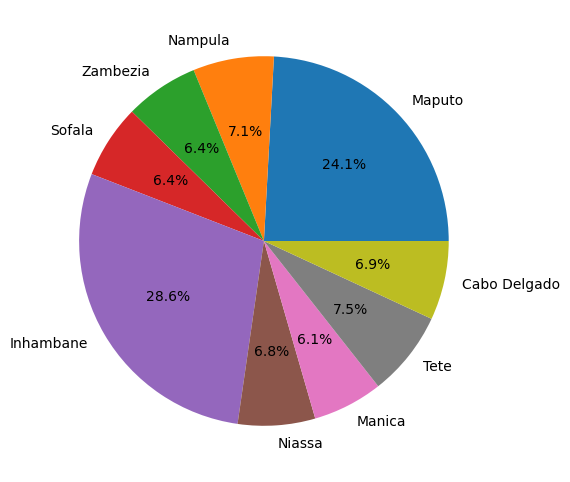

Number and fraction of cases:
Maputo:       307	24.1%
Nampula:      90	7.1%
Zambezia:     82	6.4%
Sofala:       82	6.4%
Inhambane:    364	28.6%
Niassa:       86	6.8%
Manica:       78	6.1%
Tete:         95	7.5%
Cabo Delgado: 88	6.9%


In [13]:
#Exploring the sample sizes per province. Here Maputo includes the HFS data and the importation study cases.
make_pie(metadata.loc[data2use, "province"], verbose = True)

In order to generate tables of statistics of different factors, we first define the list of factors to be included: 

In [14]:
#List of factors to analyse
factors = ['province', 'district', 'age', 'sex', 'parasitemia', \
           'pregnancy', 'occupation', 'travel', 'travel_days_728', 'season']

We now proceed to generate tables of sample sizes and population characteristics. First, we generate this table for the HFS+TES samples. 

In [15]:
pop_stats = pd.DataFrame(index = metadata.loc[data2use, "province"].unique(), \
             columns = ["N", "Mean age (SD)", "% female", 'pregnant', "travel", "% dry season"])
for prov in ["Maputo", "Inhambane", "Sofala", "Manica", "Tete", \
            "Zambezia", "Nampula", "Niassa", "Cabo Delgado"]:
    mask_prov = (metadata['source'] != 'REACT2')&(metadata["province"] == prov)
    pop_stats.loc[prov, "N"] = np.sum(mask_prov)
    mean_age = np.mean(metadata.loc[mask_prov, "age"])
    sd_age = np.std(metadata.loc[mask_prov, "age"])
    age_str = str(round(mean_age, 2)) + " (" + str(round(sd_age, 2)) + ")"
    pop_stats.loc[prov, "Mean age (SD)"] = age_str
    mask_sex = (metadata["sex"] == 'Feminino') |(metadata["sex"] == 'Femenino')
    mask_male = metadata["sex"] == 'Masculino'
    pop_stats.loc[prov, "% female"] = round(100*np.sum(mask_prov&mask_sex)/(np.sum(mask_prov&mask_sex) + np.sum(mask_prov&mask_male)), 2)
    mask_preg = (metadata["pregnancy"] == 'Sim')
    mask_npreg = metadata["pregnancy"] == 'Nao'
    pop_stats.loc[prov, "pregnant"] = round(100*np.sum(mask_prov&mask_preg)/(np.sum(mask_prov&mask_preg) + np.sum(mask_prov&mask_npreg)), 2)
    pop_stats.loc[prov, "travel"] = round(100*np.nanmean(2 - metadata.loc[mask_prov, "travel"]), 2)
    pop_stats.loc[prov, "% dry season"] = round(100*np.nanmean(metadata.loc[mask_prov, "season"] == "dry"), 2)

/tmp/ipykernel_30040/2703474183.py:16: RuntimeWarning: invalid value encountered in scalar divide
  pop_stats.loc[prov, "pregnant"] = round(100*np.sum(mask_prov&mask_preg)/(np.sum(mask_prov&mask_preg) + np.sum(mask_prov&mask_npreg)), 2)
/tmp/ipykernel_30040/2703474183.py:17: RuntimeWarning: Mean of empty slice
  pop_stats.loc[prov, "travel"] = round(100*np.nanmean(2 - metadata.loc[mask_prov, "travel"]), 2)


Notice that no samples belong to the dry season, as designed for the study. Information on travel reports or pregnancy are not available for this data. 

In [16]:
pop_stats

,N,Mean age (SD),% female,pregnant,travel,% dry season
Maputo,100,20.52 (18.62),49.49,NaN,NaN,0.0
Nampula,90,1.53 (0.95),45.56,NaN,NaN,0.0
Zambezia,82,4.71 (2.28),54.88,NaN,NaN,0.0
Sofala,82,5.53 (2.38),48.72,NaN,NaN,0.0
Inhambane,364,6.22 (2.7),54.62,NaN,NaN,0.0
Niassa,86,5.71 (2.63),43.02,NaN,NaN,0.0
Manica,78,5.65 (2.34),46.15,NaN,NaN,0.0
Tete,95,2.37 (1.51),45.74,NaN,NaN,0.0
Cabo Delgado,88,2.22 (1.27),50.0,NaN,NaN,0.0


Now we generate the table of characteristics of the importation study population from the two districts of Magude and Matutuine. 

In [17]:
pop_stats_dist = pd.DataFrame(index = ['Magude', 'Matutuine'], \
             columns = ["N", "Mean age (SD)", "% female", "% pregnant", "% travel", "% dry season"])
for dist in ['Magude', 'Matutuine']:
    mask_dist = ds_with_meta&(metadata["district"] == dist)
    pop_stats_dist.loc[dist, "N"] = np.sum(mask_dist)
    mean_age = np.mean(metadata.loc[mask_dist, "age"])
    sd_age = np.std(metadata.loc[mask_dist, "age"])
    age_str = str(round(mean_age, 2)) + " (" + str(round(sd_age, 2)) + ")"
    pop_stats_dist.loc[dist, "Mean age (SD)"] = age_str
    mask_sex = (metadata["sex"] == 'Feminino') |(metadata["sex"] == 'Femenino')
    mask_male = metadata["sex"] == 'Masculino'
    pop_stats_dist.loc[dist, "% female"] = round(100*np.sum(mask_dist&mask_sex)/(np.sum(mask_dist&mask_sex) + np.sum(mask_dist&mask_male)), 2)
    mask_preg = (metadata["pregnancy"] == 'Sim')
    mask_npreg = metadata["pregnancy"] == 'Nao'
    pop_stats_dist.loc[dist, "% pregnant"] = round(100*np.sum(mask_dist&mask_preg)/(np.sum(mask_dist&mask_preg) + np.sum(mask_dist&mask_npreg)), 2)
    pop_stats_dist.loc[dist, "% travel"] = round(100*np.nanmean(2 - metadata.loc[mask_dist, "travel"]), 2)
    pop_stats_dist.loc[dist, "% dry season"] = round(100*np.nanmean(metadata.loc[mask_dist, "season"] == "dry"), 2)

Here we visualise the table and a pie chart:  

In [18]:
pop_stats_dist

,N,Mean age (SD),% female,% pregnant,% travel,% dry season
Magude,28,22.61 (14.9),39.29,0.0,10.71,14.29
Matutuine,179,24.46 (17.58),52.51,3.03,58.1,34.08


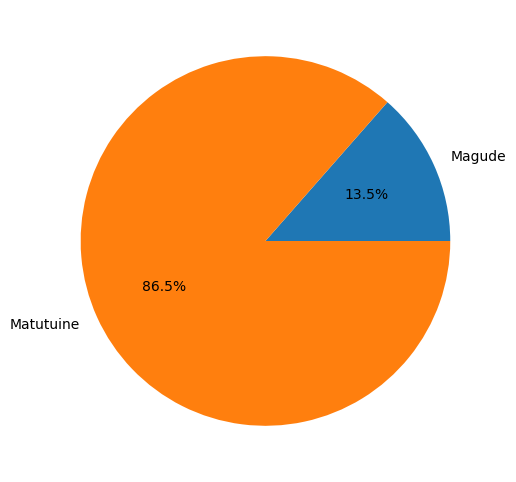

Number and fraction of cases:
Magude:    28	13.5%
Matutuine: 179	86.5%


In [19]:
make_pie(metadata.loc[ds_with_meta, "district"], verbose = True)

### Factors associated to district

In this section, we calculate the statistical significancy of the differences in different factors between the different districts (between Magude and Matutuine) and provinces (using HFS and TES samples): 

In [20]:
#Creating a simplified version of occupation for proper statistics
metadata['occupation_simp'] = metadata['occupation']
mask_occ = metadata['occupation_simp'].notnull()
for occ in ['Domestica', 'Estudante', 'Agricultor', 'Nao aplicavel']:
    mask_occ[metadata['occupation_simp'] == occ] = False
metadata.loc[mask_occ, 'occupation_simp'] = 'Other'

In [21]:
#Updating the factor list with the new occupation variable
factor_list = ['season', 'age', 'sex', 'pregnancy', 'occupation_simp', \
               'travel', 'travel_prov']

In the following script, we run a loop to analyse each factor association. For each factor, we estimate statistics across Magude and Matutuine district and apply statistical tests to assess the significance of these differences. Chi square contingency test is used for categorical variables, and a T-test for continuous variables.

In [23]:
#Setting variables where all the p-values and tables will be saved
all_p = []
all_tables = []

#Define data to be used
data_dist_mask = ds_with_meta&(metadata["district"] == 'Magude') | (metadata["district"] == 'Matutuine')
metadata['is_magude'] = pd.Series(metadata["district"] == 'Magude', dtype = float)
data_dist = metadata[data_dist_mask]

#Run loop over all factors
for var in factor_list:
    print()
    print(var)
    #categorical variables
    if var in ['district', 'season', 'us', 'sex', 'pregnancy', 'occupation_simp', 'travel', 'travel_prov']:
        if var == 'foccupation_simp': 
            mask = (data_dist[var] != 'Nao aplicavel')&(data_dist[var] != 'Outro (Especificar)')
            table_var_imp = tables.labels_2d(data_dist[mask], var, 'district')
        else: 
            table_var_imp = tables.labels_2d(data_dist, var, 'district')
        print(table_var_imp)
        stat, p, dof, expected = chi2_contingency(table_var_imp)
    #continuous variables
    else: 
        x_var = np.array(data_dist.loc[data_dist['district'] == 'Matutuine', var])
        y_var = np.array(data_dist.loc[data_dist['district'] == 'Magude', var])
        print("Mean (SD) " + var + " Matutuine:", np.mean(x_var), "(", np.std(x_var), ")")
        print("Mean (SD) " + var + " Magude:", np.mean(y_var), "(", np.std(y_var), ")")
        print("Mean (95CI) " + var + " Matutuine:", np.mean(x_var), "(", np.percentile(x_var, 2.5), ",", np.percentile(x_var, 97.5), ")")
        print("Mean (95CI) " + var + " Magude:", np.mean(y_var), "(", np.percentile(y_var, 2.5), ",", np.percentile(y_var, 97.5), ")")
        stat, p = ttest_ind(x_var, y_var)
    print("p-value:", p)
    all_p.append(p)
    all_tables.append(table_var_imp)
    print()     


season
       Matutuine  Magude
rainy        118      24
dry           61       4
p-value: 0.06017985886401949


age
Mean (SD) age Matutuine: 24.463687150837988 ( 17.58340284696514 )
Mean (SD) age Magude: 22.607142857142858 ( 14.90287432897782 )
Mean (95CI) age Matutuine: 24.463687150837988 ( 1.0 , 67.74999999999991 )
Mean (95CI) age Magude: 22.607142857142858 ( 2.35 , 52.325 )
p-value: 0.5986469047494567


sex
           Matutuine  Magude
Masculino         85      17
Feminino          94      11
p-value: 0.27189246026345937


pregnancy
     Matutuine  Magude
Nao       64.0     9.0
Sim        2.0     0.0
p-value: 1.0


occupation_simp
               Matutuine  Magude
Estudante             17       9
Other                 48      11
Nao aplicavel         50       1
Agricultor            22       3
Domestica             42       4
p-value: 0.0012303701573665152


travel
     Matutuine  Magude
2.0         75      25
1.0        104       3
p-value: 8.092245338263297e-06


travel_prov
    

Although all results are printed, we can explore them in table formats from the list saved. For example: 

In [16]:
all_tables[4]

,Matutuine,Magude
Estudante,17,9
Other,48,11
Agricultor,22,3
Domestica,42,4


### Characteristics of population who travelled

Here we generate the same tables and p-values, but restricted to the samples from cases reporting travels: 

In [17]:
#Setting variables where all the p-values and tables will be saved
all_p = []
all_tables = []

#Define data to be used, selecting only those with travel reports
data_dist_mask = ds_with_meta&(metadata["district"] == 'Magude') | (metadata["district"] == 'Matutuine')
metadata['is_magude'] = pd.Series(metadata["district"] == 'Magude', dtype = float)
data_dist = metadata[data_dist_mask&(metadata["travel"] == 1)]

#Run loop over all factors
for var in factor_list:
    print()
    print(var)
    #categorical variables
    if var in ['district', 'season', 'us', 'sex', 'pregnancy', 'occupation_simp', 'travel', 'travel_prov']:
        if var == 'occupation_simp': 
            mask = (data_dist[var] != 'Nao aplicavel')&(data_dist[var] != 'Outro (Especificar)')
            table_var_imp = tables.labels_2d(data_dist[mask], var, 'district')
        else: 
            table_var_imp = tables.labels_2d(data_dist, var, 'district')
        print(table_var_imp)
        stat, p, dof, expected = chi2_contingency(table_var_imp)
    #continuous variables
    else: 
        x_var = np.array(data_dist.loc[data_dist['district'] == 'Matutuine', var])
        y_var = np.array(data_dist.loc[data_dist['district'] == 'Magude', var])
        print("Mean (SD) " + var + " Matutuine:", np.mean(x_var), "(", np.std(x_var), ")")
        print("Mean (SD) " + var + " Magude:", np.mean(y_var), "(", np.std(y_var), ")")
        print("Mean (95CI) " + var + " Matutuine:", np.mean(x_var), "(", np.percentile(x_var, 2.5), ",", np.percentile(x_var, 97.5), ")")
        print("Mean (95CI) " + var + " Magude:", np.mean(y_var), "(", np.percentile(y_var, 2.5), ",", np.percentile(y_var, 97.5), ")")
        stat, p = ttest_ind(x_var, y_var)
    print("p-value:", p)
    all_p.append(p)
    all_tables.append(table_var_imp)
    print()     


season
       Matutuine  Magude
rainy         64       2
dry           40       1
p-value: 1.0


age
Mean (SD) age Matutuine: 25.557692307692307 ( 18.33335910882176 )
Mean (SD) age Magude: 9.0 ( 2.449489742783178 )
Mean (95CI) age Matutuine: 25.557692307692307 ( 1.5750000000000002 , 67.12499999999999 )
Mean (95CI) age Magude: 9.0 ( 6.15 , 11.85 )
p-value: 0.12434095933025105


sex
           Matutuine  Magude
Feminino          58       1
Masculino         46       2
p-value: 0.8559176286887366


pregnancy
     Matutuine  Magude
Nao         41       1
p-value: 1.0


occupation_simp
            Matutuine  Magude
Estudante         7.0     2.0
Agricultor       10.0     0.0
Domestica        27.0     0.0
Other            27.0     0.0
p-value: 0.002169034684558793


travel
     Matutuine  Magude
1.0        104       3
p-value: 1.0


travel_prov
              Matutuine  Magude
Nampula             5.0     0.0
Inhambane          58.0     1.0
Sofala              1.0     0.0
Gaza               11

## Factors associated to provinces

We finally repeat the same for the rest of the samples from the other provinces. We first visualise their sample sizes across provinces: 

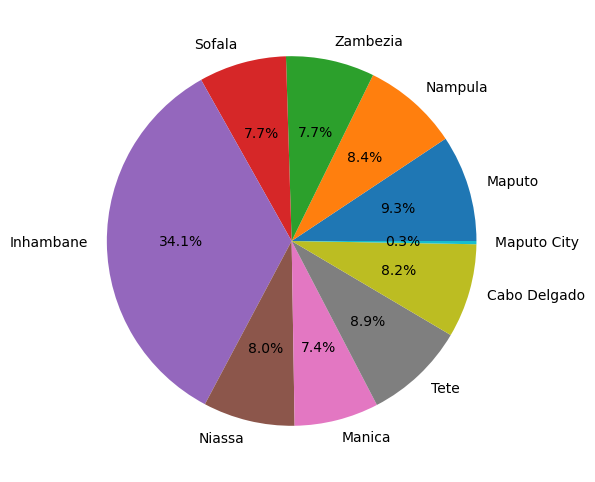

Number and fraction of cases:
Maputo:       100	9.3%
Nampula:      90	8.4%
Zambezia:     83	7.7%
Sofala:       82	7.7%
Inhambane:    365	34.1%
Niassa:       86	8.0%
Manica:       79	7.4%
Tete:         95	8.9%
Cabo Delgado: 88	8.2%
Maputo City:  3	0.3%


In [18]:
make_pie(metadata.loc[np.invert(react_mask), 'province'], verbose = True)

In this case, the statistics are limited to age and sex. 

In [19]:
#List of factors
hfs_factor_list = ['age', 'sex']
#Fixing consistency of values in variable sex
metadata.loc[metadata['sex'] == 'Femenino', 'sex'] = 'Feminino'

In [21]:
#Setting variables where all the p-values and tables will be saved
all_p = []
all_tables = []

#Define data to be used
data_prov_mask = np.invert(react_mask)
data_prov = metadata[data_prov_mask]

#Run loop over all factors
for var in hfs_factor_list:
    print()
    print(var)
    #categorical variables
    if var in ['district', 'season', 'us', 'sex', 'pregnancy', 'occupation_simp', 'travel', 'travel_prov']:
        if var == 'occupation_simp': 
            mask = (data_prov[var] != 'Nao aplicavel')&(data_prov[var] != 'Outro (Especificar)')
            table_var_imp = tables.labels_2d(data_prov[mask], var, 'province')
        else: 
            table_var_imp = tables.labels_2d(data_prov, var, 'province')
        print(table_var_imp)
        stat, p, dof, expected = chi2_contingency(table_var_imp)
    #continuous variables
    else: 
        for prov in  metadata.loc[data_prov_mask, 'province'].unique():
            x_var = np.array(data_prov.loc[data_prov['province'] == prov, var])
            print("Mean (SD) " + var + " " + prov  + ":", np.nanmean(x_var), "(", np.nanstd(x_var), ")")
            print("Mean (95CI) " + var + " " + prov  + ":", np.nanmean(x_var), "(", np.nanpercentile(x_var, 2.5), ",", np.nanpercentile(x_var, 97.5), ")")
        stat, p = ttest_ind(x_var, y_var)
    print("p-value:", p)
    all_p.append(p)
    all_tables.append(table_var_imp)
    print()     


age
Mean (SD) age Maputo: 20.524242424242424 ( 18.624102396696724 )
Mean (95CI) age Maputo: 20.524242424242424 ( 1.4 , 61.01499999999999 )
Mean (SD) age Nampula: 1.5277777777777775 ( 0.9488459527106118 )
Mean (95CI) age Nampula: 1.5277777777777775 ( 0.3333333333333333 , 3.793749999999992 )
Mean (SD) age Zambezia: 5.086746987951808 ( 4.0983326343487585 )
Mean (95CI) age Zambezia: 5.086746987951808 ( 2.0100000000000002 , 9.6 )
Mean (SD) age Sofala: 5.529999999999999 ( 2.381722066069003 )
Mean (95CI) age Sofala: 5.529999999999999 ( 2.595 , 10.1025 )
Mean (SD) age Inhambane: 6.261666666666666 ( 2.79301261086384 )
Mean (95CI) age Inhambane: 6.261666666666666 ( 2.2 , 11.502499999999998 )
Mean (SD) age Niassa: 5.705813953488371 ( 2.6295438923253904 )
Mean (95CI) age Niassa: 5.705813953488371 ( 2.0 , 10.1875 )
Mean (SD) age Manica: 5.6189873417721525 ( 2.344942089882618 )
Mean (95CI) age Manica: 5.6189873417721525 ( 2.1950000000000003 , 9.704999999999998 )
Mean (SD) age Tete: 2.36855791962174